In [1]:
from torchvision.models import resnet18
from torchvision import transforms
import numpy as np
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import pylab as pl
import time
import pyinn.ncrelu as ncrelu
import math
from IPython import display
import torch.nn.functional as F
torch.cuda.set_device(3)

In [2]:
training_data = torch.load('/data/mini_imagenet/mIN_96.pth')
testing_data = [i[-50:] for i in training_data]
training_data = [i[:-50] for i in training_data]
print(len(testing_data[0]),len(training_data[0]))

50 550


In [3]:
from gpytorch.utils.fft import fft3,ifft3
from torch.autograd import Variable, Function
from torch.nn.parameter import Parameter

class FFT3(Function):
    def __init__(self):
        super(FFT3, self).__init__()
    
    def forward(self, inp):
        return fft3(inp)
    
    def backward(self, grad):
        return ifft3(grad)
    
class FFT3_up(Function):
    def __init__(self):
        super(FFT3_up, self).__init__()
    
    def forward(self, inp):
        result = fft3(inp)
        return result
    
    def backward(self, grad):
        return ifft3(grad).sum(0).unsqueeze(0)
    
class iFFT3(Function):
    def __init__(self):
        super(iFFT3, self).__init__()
        
    def forward(self, inp):
        return ifft3(inp)
    
    def backward(self, grad):
        return fft3(grad)
    
class Conv3dF(nn.Module):
    def __init__(self,nchannels,size,padding=False):
        super(Conv3dF,self).__init__()
        self.nchannels = nchannels
        self.fft = FFT3()
        self.ifft = iFFT3()
        self.fftup = FFT3_up()
        self.padding = padding
        self.striper = Variable(torch.bernoulli(torch.ones(1,nchannels,1,1)/2)*2-1, requires_grad=False).cuda()
        self.padder = (nn.ConstantPad2d((0,size-3+2,0,size-3+2),0) if padding else 
                       nn.ConstantPad2d((0,size-3,0,size-3),0))
        self.weights = Parameter(torch.randn(1,nchannels,3,3)*2/math.sqrt(nchannels)) 
                                                # TODO proper weight initialization
        
    def forward(self, inp):
        fi = self.fft(F.pad(self.striper*inp,(1,1,1,1))) if self.padding else self.fft(self.striper*inp)
        fw = self.fftup(self.padder(self.weights))
        result = torch.cat([(fi[:,:,:,:,0]*fw[:,:,:,:,0]-fi[:,:,:,:,1]*fw[:,:,:,:,1]).unsqueeze(4),
                            (fi[:,:,:,:,0]*fw[:,:,:,:,1]+fi[:,:,:,:,1]*fw[:,:,:,:,0]).unsqueeze(4)],dim=4)
#         print("GOTHERE fft elem mult")
        return self.ifft(result)[:,:,1:-1,1:-1].contiguous() if self.padding else self.ifft(result)
        

In [11]:
class fftBlock(nn.Module):
    def __init__(self, size, imsize, padding=False):
        super(fftBlock, self).__init__()
        self.layers = nn.Sequential(
            Conv3dF(size, imsize, padding),
            nn.BatchNorm2d(size)
        )
        
    def forward(self, inp):
#         print("GOTHERE fft block",inp.size())
        return ncrelu(self.layers(inp))
    
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
#         print("GOTHERE block",inp.size())
        return ncrelu(self.layers(inp))

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.process = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(128,128),
            nn.MaxPool2d(2),
            Block(256,256),
            nn.MaxPool2d(2),
            fftBlock(512,12,padding=True),
            nn.MaxPool2d(2),
            fftBlock(1024,6,padding=True),
            nn.AvgPool2d((6,6)))
        self.final = nn.Sequential(
            nn.Linear(2048,100)
        )
            
    def forward(self, inp):
        out = self.process(inp)
        return self.final(out.view(-1, 2048))


In [15]:
model.eval()
evaluate(model, criterion, testing_data, shot=50)

(2.029795287489891, 0.4926)

In [5]:
standardize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])
            ])

alter = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(80,padding=10),
            standardize
            ])

def batchmaker(theset, way=20, shot=1, alterful=False):
    classes = np.random.choice(len(theset),way)
    if alterful:
        li = [torch.cat([alter(theset[cl][i]).view(1,3,80,80) for i in 
                         np.random.choice(len(theset[0]),shot)],dim=0).float()
              for cl in classes]
    else:
        li = [torch.cat([standardize(theset[cl][i]).view(1,3,80,80) for i in 
                         np.random.choice(len(theset[0]),shot)],dim=0).float()
              for cl in classes]
    support = torch.cat([t[:shot,:,:,:] for t in li],dim=0)
    stargs = torch.LongTensor(np.repeat(classes, shot))
#     query = torch.cat([t[trainshot:,:,:,:] for t in li],dim=0)
#     qtargs = torch.LongTensor([i//shot for i in range(testshot*way)])
    return(Variable(support, volatile=(not alterful)).cuda(),
           Variable(stargs, volatile=(not alterful)).cuda()
          )
# batchmaker(training_data,shot=2)

In [6]:
criterion = nn.CrossEntropyLoss().cuda()
# optimizer = torch.optim.Adam(model.parameters())

In [7]:
def evaluate(model, criterion, testing_data, shot=10, way=100):
    support, targs = batchmaker(testing_data, way=way, shot=shot)
    assert (shot*way)%20==0
    batches = int(shot*way/20)
    support = support.view(batches, 20, 3, 80, 80)
    targs = targs.view(batches, 20)
    acc = 0
    loss = 0
    for i in range(batches):
        preds = model(support[i,:,:,:,:])
        loss += criterion(preds, targs[i,:]).data[0]
        _,bins = torch.max(preds, 1)
        acc += torch.sum(torch.eq(bins,targs[i,:])).data[0]
    acc = float(acc)/shot/way
    loss = float(loss)/batches
    return loss, acc

In [12]:
model = ENCODER()
model.cuda()
nweights = sum([i.numel() for i in list(model.parameters())])
print(nweights," parameters in neural net.")

999076  parameters in neural net.


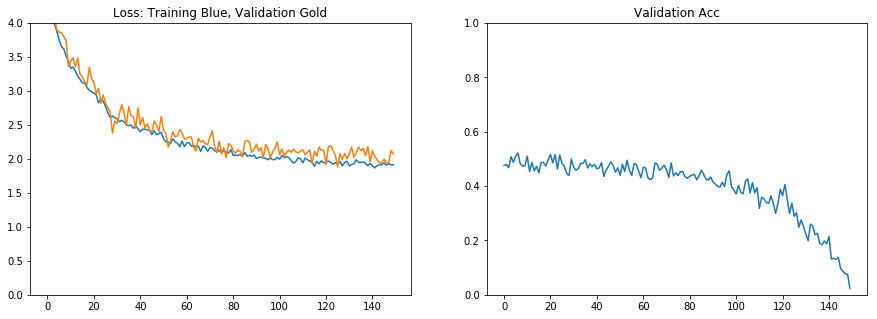

Train loss is: 1.9121760475635527
Validation accuracy is: 0.47600000000000003
Validation loss is: 2.0721118104457856

2008.0359811782837


In [13]:
%matplotlib inline

vbity = 200
epoch = 5000
start = time.time()
losstracker = []
evalacctracker = []
evallosstracker = []
runningloss = 0
limit = 6
for it in range(limit*epoch):
    if it%50==0:
        print(it)
    
    # Build batch
    support, targs = batchmaker(training_data, alterful=True)
    
    # Predict
    model.zero_grad()
    preds = model(support)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    
    # Backprop
    if it%epoch == 0:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001/(2**(it//epoch)))
    loss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        model = model.eval()
        evalloss, evalacc = evaluate(model, criterion, testing_data, shot=20)
        model = model.train()
        evallosstracker.append(evalloss)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.ylim((0,4))
#         pl.xlim((0,limit*epoch))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
        pl.ylim((0,1))
#         pl.xlim((0,limit*epoch))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+"\n")
        runningloss = 0
        print(time.time()-start)

In [14]:
name = "hybrid_1024"
torch.save((embed,model,losstracker,evallosstracker,evalacctracker),'saved_models/'+name+'.pth')

0.47816999999999998